# Gaussian Process Regression

Previously we attempted to approximate a function $f(x)$ as a Gaussian of the form $\mathcal{N}(m(x), k(x,x'))$ using GPR.

Mathematically, 
<body> <center>$ y = f(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(0,\sigma^2)$</center><body>
    
As stated above, we approximate $f(x) \sim GP(m(x), k(x,x'))$

In the example, the observation was noise (note $\epsilon$). In this example, let us include noise on the input side too. Take the example given below

A vehicle is moving at 2m/s (plus an additional noise $\mathcal{N}(0,0.09)$) in a particular direction. It's position is obtained through a noisy sensor ($\mathcal{N}(0,0.25)$). It is our task to determine a model that can fit the data obtained from the sensor. Assume the vehicle starts from rest.

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline

The true behaviour of the vehicle is obviously still described by 
<body><center> $y = vx$ </center></body>

Text(0, 0.5, 'Positon(m)')

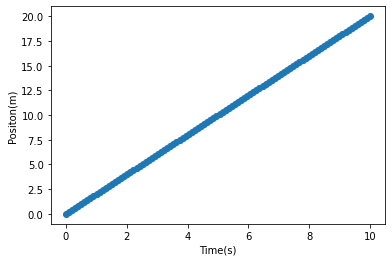

In [2]:
train_X = np.linspace(0,10,100)
train_Y = 2 * train_X
plt.scatter(train_X, train_Y)
plt.xlabel('Time(s)')
plt.ylabel('Positon(m)')

The above is a perfect (noise-free system). Now consider the same with noise (as described in the question).

Text(0, 0.5, 'Positon(m)')

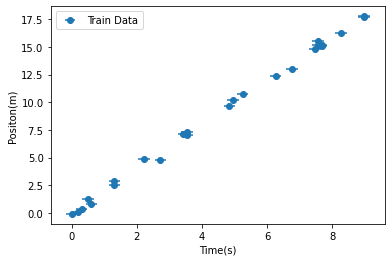

In [3]:
np.random.seed(12)
σ = np.sqrt(0.25)
σ_x = np.sqrt(0.09)
train_x_mean = torch.linspace(0,10,100)[np.random.randint(0,100,25)]
train_x_std_dev = torch.ones(train_x_mean.size()) * (σ_x**2)
train_y = torch.Tensor(2 * train_x_mean + torch.randn(train_x_mean.size()) * σ**2)
fig, ax = plt.subplots(1,1)
ax.errorbar(train_x_mean, train_y, xerr=(train_x_std_dev * 2), fmt = "o", label="Train Data")
ax.legend()
ax.set_xlabel('Time(s)')
ax.set_ylabel('Positon(m)')

This is a noisy sensor reading. Now, from high school physics, we know that the above model is given by 

<body> <center> $\dfrac{dy}{dx} = v$ </center> </body>

or

<body> <center> $y = vx + \epsilon$ </center> </body>

where, $v$ is the velocity, $x$ is the time, $y$ is the position and $\epsilon$ is the noise as described in the question. We are given $v|_{x = 0} = 0$

Since we are also given an uncertainty in the velocity, we have to account for it in our model. We can do this by using a distributional kernel, if we know the underlying distribution of the uncertain input, or by using variational inference.

First, let us see the example using a distributional kernel.

In [4]:
train_x_distributional = torch.stack((train_x_mean, (train_x_std_dev**2).log()), dim=1)

In [67]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.GaussianSymmetrizedKLKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x_distributional, train_y, likelihood)

Here, we have defined an Exact Gaussian Process model (Exact in the sense that the prior, likelihood, and the posterior are all Gaussian distributions).

We initialise the class using the ExactGP model predefined in GPyTorch. The initialisation involves declaring the training data (X,Y) and the likelihood distribution.

Further, when initialising, we initialise the mean and covariance of the GP model. Note here that the covariance module is now a Gaussian Symmetric KL Kernel instead of an RBF Kernel. This kernel is attempting to find the ideal parameters of $q(u)$ such that $KL(q(u)||p(u))$ is minimum ($KL(.||.)$ stands for the Kullback Liebler Divergence).

Next, we define the forward pass. The forward pass is used to predict when a new $x$ is provided. The forward pass returns the multivariate normal distribution with the proper mean and covariance based on the $x$.

In [68]:
for x in model.named_parameters():
    print(x)

('likelihood.noise_covar.raw_noise', Parameter containing:
tensor([0.], requires_grad=True))
('mean_module.constant', Parameter containing:
tensor([0.], requires_grad=True))
('covar_module.raw_outputscale', Parameter containing:
tensor(0., requires_grad=True))
('covar_module.base_kernel.raw_lengthscale', Parameter containing:
tensor([[0.]], requires_grad=True))


The KL between two Gaussians is given by:
    
<body> <center> $KL(p,q) = log\dfrac{\sigma_p}{\sigma_q} + \dfrac{\sigma_p^2 + (\mu_p - \mu_q)^2}{2\sigma_q^2} - \dfrac{1}{2}$ </center> </body>

By training, we are attempting to minimise the divergence ("distance") between the two distributions.

In [69]:
# Find optimal model hyperparameters
model.train()
likelihood.train()
training_iter = 3000

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x_distributional)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()

In [70]:
model.eval()
likelihood.eval()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [71]:
test_x = torch.linspace(0, 10, 100)
test_x_distributional = torch.stack((test_x, (σ_x * torch.ones_like(test_x)).log()), dim=1)
f_pred = model(test_x_distributional)
y_pred = likelihood(model(test_x_distributional))

f_mean = f_pred.mean
f_var = f_pred.variance
f_covar = f_pred.covariance_matrix
f_samples = f_pred.sample(sample_shape=torch.Size([100]))

/Users/jaymehta/miniconda3/lib/python3.7/site-packages/gpytorch/lazy/lazy_tensor.py:1356: NumericalWarning: Runtime Error when computing Cholesky decomposition: Matrix not positive definite after repeatedly adding jitter up to 1.0e-04. Original error on first attempt: cholesky_cpu: U(2,2) is zero, singular U.. Using RootDecomposition.
  NumericalWarning,


In [72]:
with torch.no_grad(), gpytorch.settings.fast_pred_var():
#     test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x_distributional))

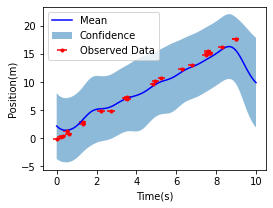

In [73]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_x_mean.numpy(), train_y.numpy(), xerr=(train_x_std_dev * 2), fmt = 'r.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Mean', 'Confidence', 'Observed Data'])
    ax.set_xlabel('Time(s)')
    ax.set_ylabel('Position(m)')

Note here that the blue line is almost having the correct slop until the end of the data where there is a lack of data. The line is flattening as it starts to revert to the prior for $\mu$ which was a constant.